## Importing packages

In [1]:
# Basic packages
import warnings
import numpy as np
import pandas as pd

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf

# Pipeline packages
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.pipeline import (Pipeline, make_pipeline)
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.preprocessing import OneHotEncoder

# Missing data imputation package
from sklearn.impute import KNNImputer

# Cross validation packages
from sklearn.model_selection import (StratifiedKFold, cross_val_score, GridSearchCV)

# Modelling packages
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from statsmodels.formula.api import logit

# Model validation and scoring packages
from sklearn.metrics import (accuracy_score, roc_auc_score)
from sklearn.metrics import SCORERS

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.



In [2]:
init_notebook_mode(connected=True)
%matplotlib inline
sns.set_style("dark")
plt.style.use("ggplot")
cf.go_offline()
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', '{:.2f}'.format)
set_config(display="diagram")
# plt.style.available
scorers = []
for score in SCORERS.keys():
    scorers.append(score)
# print(scorers)

## Loading data

In [3]:
df_train = pd.read_csv("../input/titanic/train.csv")
df_test = pd.read_csv("../input/titanic/test.csv")
for df in [df_train, df_test]:
    print(df.info(), end="\n\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pc

In [4]:
for df in [df_train, df_test]:
    df.drop(columns=["Name", "Ticket", "Cabin"], inplace=True)

## Exploratory Data Analysis

### Visualizing proportion of training dataset feature

In [5]:
df_train_categorized = df_train.copy().replace(
    {
       "Survived": {0: "No", 1: "Yes"},
        "Pclass": {1: "1st", 2: "2nd", 3: "3rd"},
        "Sex": {"male": "Male", "female": "Female"},
        "Embarked": {"C": "Cherbourg", "Q": "Queenstown", "S": "Southampton"}
    }
)
df_train_categorized = df_train_categorized.rename(
        columns={"Pclass": "Passenger Class", 
                 "SibSp": "Number of Siblings or Spouses Aboard", 
                 "Parch": "Number of Parents or Children Aboard"}
)

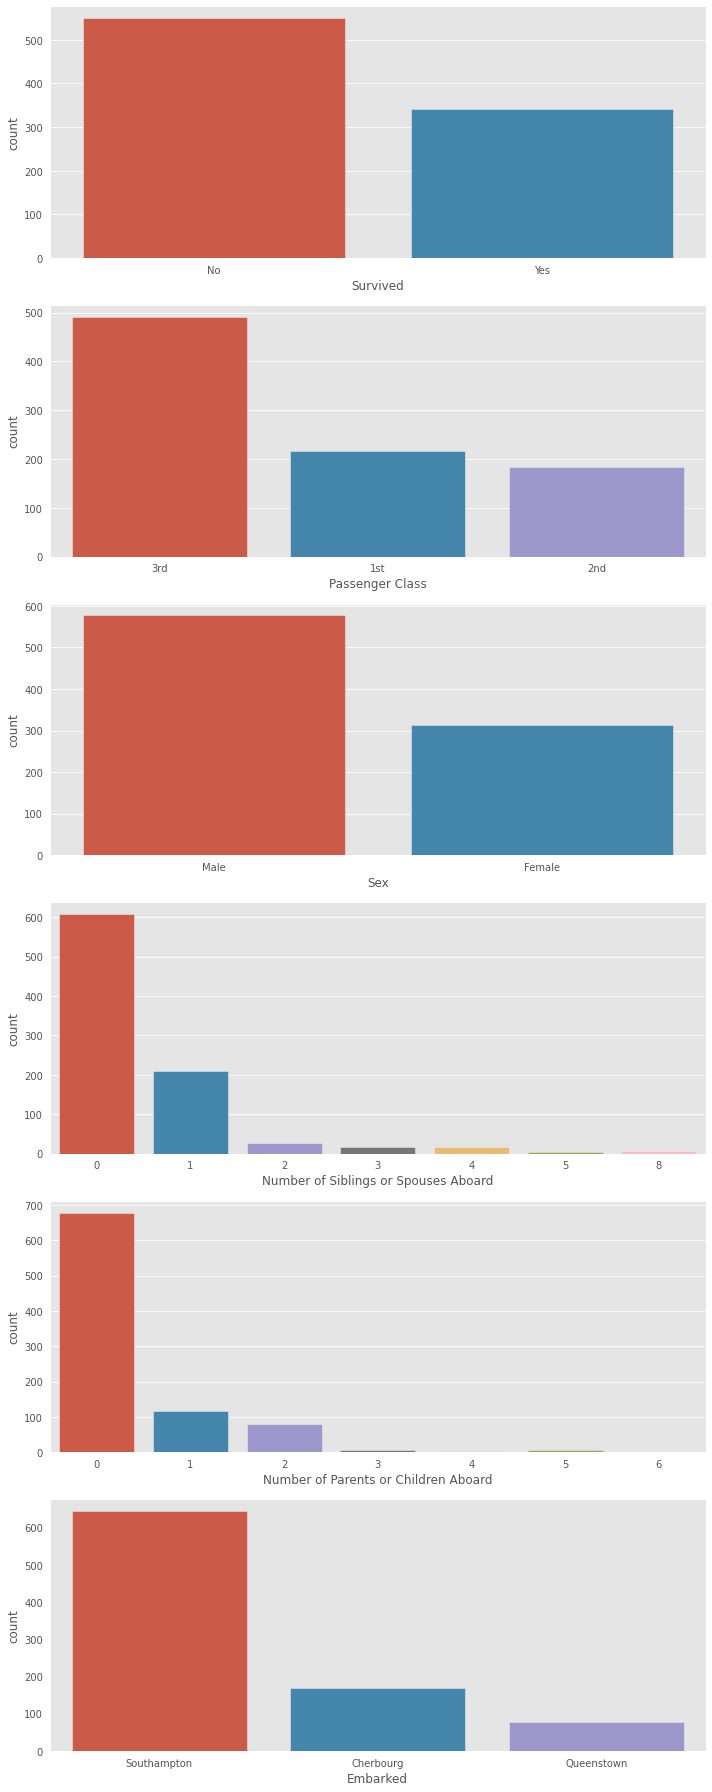

In [6]:
graph_cols = ['Survived', 'Passenger Class', 'Sex', 
              'Number of Siblings or Spouses Aboard', 
              'Number of Parents or Children Aboard', 
              'Embarked']
fig_1, ax_1 = plt.subplots(nrows=6, ncols=1, figsize=(10, 25))
ax_1 = ax_1.flatten()

i = 0
for column in graph_cols:
    sns.countplot(df_train_categorized[column], x=column, ax=ax_1[i])
    i+=1
    
plt.grid(False)
plt.tight_layout()

## Data Coding & Missing Data Imputation

### Data code notes

Fare_band:</br>
0: -1 - 8</br>
1: 8 - 14</br>
2: 14 - 31</br>
3: 31 - 512</br></br>
Embarked:</br>
Queenstown: 0</br>
Cherbourg: 1</br>
Southampton: 2</br></br>
Is_alone:</br>
0: no</br>
1: yes</br>

In [7]:
print(df_train.columns)
print(df_test.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')


In [8]:
PassengerId_ = []
for df in [df_train, df_test]:
    x = df.copy()["PassengerId"]
    PassengerId_.append(x)
    df.drop(columns="PassengerId", inplace=True)
    
df_survived = df_train["Survived"]
df_train = df_train.drop(columns="Survived")

In [9]:
df_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.00,1,0,7.25,S
1,1,female,38.00,1,0,71.28,C
2,3,female,26.00,0,0,7.92,S
3,1,female,35.00,1,0,53.10,S
4,3,male,35.00,0,0,8.05,S


## Transformation Pipeline

### Pipeline classes

In [10]:
class Encode_Impute(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x = x.replace(
            {
                "Sex": {"male": 0, "female": 1},
                "Embarked": {"Q": 0, "C": 1, "S": 2}
            }
        )
        x["Fare_band"] = pd.qcut(x=x["Fare"], q=4, precision=0, labels=[0, 1, 2, 3])
        x = x.drop(columns="Fare")
        imp_cols = [col for col in x.columns]
        impute = KNNImputer(n_neighbors=3)
        x[imp_cols] = impute.fit_transform(x[imp_cols])
        x["Age"] = x["Age"]
        return x
    
class EncodeFeatures(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x = x.replace(
            {
                "Sex": {0: "male", 1: "female"},
                "Embarked": {0: "Q", 1: "C", 2: "S"}
            }
        )
        col_names = ["female", "male", "cherbourg", "queenstown", "southampton"]
        ohe = OneHotEncoder()
        array = ohe.fit_transform(x[["Sex", "Embarked"]]).toarray()
        for i in range(len(array.T)):
            x[col_names[i]] = array.T[i]
        x = x.drop(columns=["Sex", "Embarked"])
        return x
    
class Is_Alone(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x.loc[(x["SibSp"] > 0) | (x["Parch"] > 0), "Is_Alone"] = 1
        x["Is_Alone"] = x["Is_Alone"].fillna(value=0)
        return x
    
class Optimized_Cols(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x["Age"] = x["Age"].apply(np.ceil)
        for col in x.columns:
            x[col] = x[col].astype(np.int16)
        return x

#### Chaining classes as a pipeline

In [11]:
pipe_1 = Pipeline(
    [
        ("imputation", Encode_Impute()),
        ("encoding", EncodeFeatures()),
        ("alone", Is_Alone()),
        ("optimize", Optimized_Cols())
    ]
)

#### Data transformation through pipeline

In [12]:
piped_train = pipe_1.fit_transform(df_train)
piped_test = pipe_1.fit_transform(df_test)
# for df in [piped_train, piped_test]:
#     df.drop(columns=["male", "queenstown"], inplace=True)

### Visualizing correlation between variables of processed data

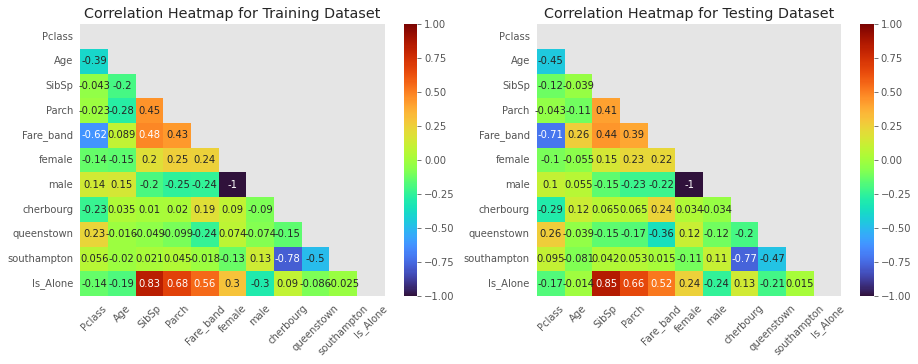

In [13]:
corr_train = piped_train.corr(method="spearman")
corr_test = piped_test.corr(method="spearman")
corr_mask_train = np.triu(np.ones_like(corr_train))
corr_mask_test = np.triu(np.ones_like(corr_test))

fig_2, ax_2 = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.heatmap(corr_train, ax=ax_2[0], cmap="turbo", annot=True, vmin=-1, vmax=1, mask=corr_mask_train)
ax_2[0].set_title("Correlation Heatmap for Training Dataset")
ax_2[0].tick_params(axis="x", rotation=45)
sns.heatmap(corr_test, ax=ax_2[1], cmap="turbo", annot=True, vmin=-1, vmax=1, mask=corr_mask_test)
ax_2[1].set_title("Correlation Heatmap for Testing Dataset")
ax_2[1].tick_params(axis="x", rotation=45)

## Modeling using the following algorithms:</br>
- Logistic Regression</br>
- C-support Vector Classification of Support Vector Machine (SVM) for 2-category Dependent Variable</br>
- K Nearest Neightbors</br>
- Decision Tree Classifier</br>
- Random Forest Classifier

### Logistic Regression

#### Finding the best parameter for Logistic Regression

In [14]:
params_logreg_GS = {"solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}
logreg_GS = LogisticRegression()
GS_logreg = GridSearchCV(
    estimator=logreg_GS,
    cv=5,
    param_grid=params_logreg_GS, 
    scoring=["r2", "accuracy", "roc_auc"],
    refit="accuracy",
    verbose=3
)
GS_logreg.fit(piped_train, df_survived)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END solver=newton-cg; accuracy: (test=0.793) r2: (test=0.127) roc_auc: (test=0.831) total time=   0.0s
[CV 2/5] END solver=newton-cg; accuracy: (test=0.803) r2: (test=0.167) roc_auc: (test=0.835) total time=   0.0s
[CV 3/5] END solver=newton-cg; accuracy: (test=0.792) r2: (test=0.120) roc_auc: (test=0.861) total time=   0.0s
[CV 4/5] END solver=newton-cg; accuracy: (test=0.798) r2: (test=0.143) roc_auc: (test=0.856) total time=   0.0s
[CV 5/5] END solver=newton-cg; accuracy: (test=0.820) r2: (test=0.243) roc_auc: (test=0.883) total time=   0.0s
[CV 1/5] END solver=lbfgs; accuracy: (test=0.793) r2: (test=0.127) roc_auc: (test=0.831) total time=   0.0s
[CV 2/5] END solver=lbfgs; accuracy: (test=0.803) r2: (test=0.167) roc_auc: (test=0.836) total time=   0.0s
[CV 3/5] END solver=lbfgs; accuracy: (test=0.781) r2: (test=0.072) roc_auc: (test=0.861) total time=   0.0s
[CV 4/5] END solver=lbfgs; accuracy: (test=0.798) r2: (t

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             refit='accuracy', scoring=['r2', 'accuracy', 'roc_auc'],
             verbose=3)

In [15]:
solver_GS_logreg = GS_logreg.best_params_["solver"]
acc_GS_logreg = round(GS_logreg.best_score_*100, 2)
print(f"Best parameter for Logistic Regression is with {solver_GS_logreg} with an accuracy of {acc_GS_logreg}%")

Best parameter for Logistic Regression is with newton-cg with an accuracy of 80.14%


#### Modeling logistic regression

In [16]:
for df in[piped_train, piped_test]:
    df.drop(columns=["male", "queenstown"], inplace=True)

In [17]:
best_logreg = LogisticRegression(solver="newton-cg")
# pipe_2 = make_pipeline(Encode_Impute(), EncodeFeatures(), Is_Alone(), Optimized_Cols(), logreg)
# cross_val_score(pipe_2, df_train, y=df_survived, cv=10, scoring="accuracy")
best_logreg.fit(piped_train, df_survived)
coeff_logreg = pd.DataFrame({"Coefficient": best_logreg.coef_[0]}, index=piped_train.columns)
print("Resulting Coefficient for Logistic Regression")
print(coeff_logreg.sort_index(axis="index", ascending=True))

Resulting Coefficient for Logistic Regression
             Coefficient
Age                -0.04
Fare_band           0.26
Is_Alone            0.55
Parch              -0.26
Pclass             -0.93
SibSp              -0.59
cherbourg          -0.08
female              2.46
southampton        -0.40


#### Predictions for Logistic Regression

In [18]:
pred_logreg = best_logreg.predict(piped_test)

In [19]:
# f_GS_logreg_data = piped_train.copy()
# f_GS_logreg_data["Survived"] = df_survived
# f_GS_logreg = logit("Survived ~ Pclass + Age + SibSp + Parch + Fare_band + female + cherbourg + southampton + Is_Alone",
#                    data=f_GS_logreg_data).fit()
# f_GS_logreg.summary()
# dir(f_GS_logreg)  # attributes of logistic regression in statsmodels

### C-support Vector Classification of Support Vector Machine (SVM) for 2-category Dependent Variable

#### Finding the best parameter for C-SVM for 2-category DV

In [20]:
params_csvm_GS = {"C": np.linspace(1,20,20),
                 "decision_function_shape": ["ovo", "ovr"]}
csvc = SVC()
GS_csvc = GridSearchCV(
    estimator=csvc,
    cv=5,
    param_grid=params_csvm_GS, 
    scoring=["r2", "accuracy", "roc_auc"],
    refit="accuracy",
    verbose=3
)
GS_csvc.fit(piped_train, df_survived)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END C=1.0, decision_function_shape=ovo; accuracy: (test=0.648) r2: (test=-0.486) roc_auc: (test=0.709) total time=   0.0s
[CV 2/5] END C=1.0, decision_function_shape=ovo; accuracy: (test=0.640) r2: (test=-0.523) roc_auc: (test=0.793) total time=   0.0s
[CV 3/5] END C=1.0, decision_function_shape=ovo; accuracy: (test=0.624) r2: (test=-0.594) roc_auc: (test=0.811) total time=   0.0s
[CV 4/5] END C=1.0, decision_function_shape=ovo; accuracy: (test=0.646) r2: (test=-0.499) roc_auc: (test=0.841) total time=   0.0s
[CV 5/5] END C=1.0, decision_function_shape=ovo; accuracy: (test=0.657) r2: (test=-0.444) roc_auc: (test=0.827) total time=   0.0s
[CV 1/5] END C=1.0, decision_function_shape=ovr; accuracy: (test=0.648) r2: (test=-0.486) roc_auc: (test=0.709) total time=   0.0s
[CV 2/5] END C=1.0, decision_function_shape=ovr; accuracy: (test=0.640) r2: (test=-0.523) roc_auc: (test=0.793) total time=   0.0s
[CV 3/5] END C=1.0, d

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.]),
                         'decision_function_shape': ['ovo', 'ovr']},
             refit='accuracy', scoring=['r2', 'accuracy', 'roc_auc'],
             verbose=3)

In [21]:
acc_GS_csvc = round(GS_csvc.best_score_*100, 2)
C_GS_csvc = GS_csvc.best_params_["C"]
dec_GS_csvc = GS_csvc.best_params_["decision_function_shape"]
print(f"Best parameter for C-SVM is with C of {C_GS_csvc:.0f} and decision function shape of {dec_GS_csvc} with an accuracy of {acc_GS_csvc}%")

Best parameter for C-SVM is with C of 20 and decision function shape of ovo with an accuracy of 81.7%


#### Modeling C-SVM

In [22]:
best_csvc = SVC(C=20, decision_function_shape="ovo")
best_csvc.fit(piped_train, df_survived)

fit_best_csvc = best_csvc.fit_status_
nfeat_best_csvc = best_csvc.n_features_in_

#### Predictions for C-SVM

In [23]:
pred_csvc = best_csvc.predict(piped_test)

### K Nearest Neighbors

#### Finding best parameters for KNN

In [24]:
params_KNN_GS = {
    "n_neighbors": np.linspace(1, 25, 25).astype(np.int16),
    "algorithm": ["ball_tree", "kd_tree", "brute"]
}
KNN_GS = KNeighborsClassifier()
GS_KNN = GridSearchCV(
    estimator=KNN_GS,
    cv=5,
    param_grid=params_KNN_GS, 
    scoring="accuracy",
    refit="accuracy",
    verbose=3
)
GS_KNN.fit(piped_train, df_survived)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END algorithm=ball_tree, n_neighbors=1;, score=0.709 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, n_neighbors=1;, score=0.691 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, n_neighbors=1;, score=0.747 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, n_neighbors=1;, score=0.792 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, n_neighbors=1;, score=0.764 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, n_neighbors=2;, score=0.721 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, n_neighbors=2;, score=0.725 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, n_neighbors=2;, score=0.764 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, n_neighbors=2;, score=0.770 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, n_neighbors=2;, score=0.764 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, n_neighbors=3;, score=0.737 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, n_neighbors=3

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25], dtype=int16)},
             refit='accuracy', scoring='accuracy', verbose=3)

In [25]:
n_GS_KNN = GS_KNN.best_params_["n_neighbors"]
al_GS_KNN = GS_KNN.best_params_["algorithm"]
acc_GS_KNN = round(GS_KNN.best_score_*100, 2)
print(f"Best parameter for KNN is with {n_GS_KNN} neighbors under {al_GS_KNN} algorithm with an accuracy of {acc_GS_KNN}%")

Best parameter for KNN is with 5 neighbors under ball_tree algorithm with an accuracy of 79.13%


#### Modeling KNN

In [26]:
knn = KNeighborsClassifier(n_neighbors=5, algorithm="brute")
knn.fit(piped_train, df_survived)

KNeighborsClassifier(algorithm='brute')

In [27]:
pred_knn = knn.predict(piped_test)

### Decision Tree Classifier

#### Finding the best parameter for Decision Tree

In [28]:
params_dtree_GS = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"]
}
dtree_GS = DecisionTreeClassifier()
GS_dtree = GridSearchCV(
    estimator=dtree_GS,
    cv=5,
    param_grid=params_dtree_GS, 
    scoring="accuracy",
    refit="accuracy",
    verbose=3
)
GS_dtree.fit(piped_train, df_survived)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....criterion=gini, splitter=best;, score=0.715 total time=   0.0s
[CV 2/5] END .....criterion=gini, splitter=best;, score=0.787 total time=   0.0s
[CV 3/5] END .....criterion=gini, splitter=best;, score=0.798 total time=   0.0s
[CV 4/5] END .....criterion=gini, splitter=best;, score=0.809 total time=   0.0s
[CV 5/5] END .....criterion=gini, splitter=best;, score=0.803 total time=   0.0s
[CV 1/5] END ...criterion=gini, splitter=random;, score=0.749 total time=   0.0s
[CV 2/5] END ...criterion=gini, splitter=random;, score=0.764 total time=   0.0s
[CV 3/5] END ...criterion=gini, splitter=random;, score=0.787 total time=   0.0s
[CV 4/5] END ...criterion=gini, splitter=random;, score=0.770 total time=   0.0s
[CV 5/5] END ...criterion=gini, splitter=random;, score=0.820 total time=   0.0s
[CV 1/5] END ..criterion=entropy, splitter=best;, score=0.726 total time=   0.0s
[CV 2/5] END ..criterion=entropy, splitter=best;,

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'splitter': ['best', 'random']},
             refit='accuracy', scoring='accuracy', verbose=3)

In [29]:
criterion_GS_dtree = GS_dtree.best_params_["criterion"]
splitter_GS_dtree = GS_dtree.best_params_["splitter"]
acc_GS_dtree = round(GS_dtree.best_score_*100, 2)
print(f"Best parameter for Decision Tree Classifier is with {criterion_GS_dtree} criterion and {splitter_GS_dtree} splitter that has an accuracy of {acc_GS_dtree}%")

Best parameter for Decision Tree Classifier is with entropy criterion and best splitter that has an accuracy of 78.68%


#### Modeling Decision Tree Classifier

In [30]:
best_dtree = DecisionTreeClassifier(criterion="entropy", splitter="best")
best_dtree.fit(piped_train, df_survived)

DecisionTreeClassifier(criterion='entropy')

In [31]:
pred_dtree = best_dtree.predict(piped_test)

### Random Forest

#### Finding best parameter for Random Forest

In [32]:
np.linspace(0,3,13)

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  ])

In [33]:
params_rf_GS = {
    "n_estimators": np.linspace(50,500,10).astype(np.int32),
    "criterion": ["gini", "entropy", "log_loss"],
    "bootstrap": [True, False]
}
rf_GS = RandomForestClassifier()
GS_rf = GridSearchCV(
    estimator=rf_GS,
    cv=5,
    param_grid=params_rf_GS,
    scoring="accuracy",
    refit="accuracy",
    verbose=3
)
GS_rf.fit(piped_train, df_survived)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END bootstrap=True, criterion=gini, n_estimators=50;, score=0.749 total time=   0.1s
[CV 2/5] END bootstrap=True, criterion=gini, n_estimators=50;, score=0.770 total time=   0.1s
[CV 3/5] END bootstrap=True, criterion=gini, n_estimators=50;, score=0.815 total time=   0.1s
[CV 4/5] END bootstrap=True, criterion=gini, n_estimators=50;, score=0.792 total time=   0.1s
[CV 5/5] END bootstrap=True, criterion=gini, n_estimators=50;, score=0.831 total time=   0.1s
[CV 1/5] END bootstrap=True, criterion=gini, n_estimators=100;, score=0.771 total time=   0.2s
[CV 2/5] END bootstrap=True, criterion=gini, n_estimators=100;, score=0.775 total time=   0.2s
[CV 3/5] END bootstrap=True, criterion=gini, n_estimators=100;, score=0.826 total time=   0.2s
[CV 4/5] END bootstrap=True, criterion=gini, n_estimators=100;, score=0.792 total time=   0.2s
[CV 5/5] END bootstrap=True, criterion=gini, n_estimators=100;, score=0.820 total time= 

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500], dtype=int32)},
             refit='accuracy', scoring='accuracy', verbose=3)

In [34]:
n_GS_rf = GS_rf.best_params_["n_estimators"]
criterion_GS_rf = GS_rf.best_params_["criterion"]
boot_GS_rf = GS_rf.best_params_["bootstrap"]
acc_GS_rf = round(GS_rf.best_score_*100,2)
print(f"Best parameter for Random Forest Classifier is with {n_GS_rf} number of estimator, {criterion_GS_rf} criterion and {boot_GS_rf} bootstrapped that has an accuracy of {acc_GS_rf}%")

Best parameter for Random Forest Classifier is with 150 number of estimator, entropy criterion and True bootstrapped that has an accuracy of 80.25%


#### Modeling Random Forest Classifier

In [35]:
best_rf = RandomForestClassifier(n_estimators=150, criterion="entropy", bootstrap=True)
best_rf.fit(piped_train, df_survived)

RandomForestClassifier(criterion='entropy', n_estimators=150)

In [36]:
pred_rf = best_rf.predict(piped_test)

In [37]:
model_results = pd.DataFrame({"Model": ["Logistic Regression", "C Support Vector Machine", "K Nearest Neighbors",
                                      "Decision Tree", "Random Forest"],
                              "Score": [acc_GS_logreg, acc_GS_csvc, acc_GS_KNN, acc_GS_dtree, acc_GS_rf]})
model_results = model_results.sort_values(by="Score", ascending=False).set_index("Model")
model_results

,Score
Model,
C Support Vector Machine,81.70
Random Forest,80.25
Logistic Regression,80.14
K Nearest Neighbors,79.13
Decision Tree,78.68


#### As a result of comparing the average accuracy across cross validation splits of the 5 classification algorithms,<br>C-Support Vector Machine as it has the greatest value of accuracy

In [38]:
df_submission = pd.DataFrame(PassengerId_[1])
df_submission["Survived"] = pred_csvc
df_submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


#### Saving to csv file

In [39]:
df_submission.to_csv("submission_1.csv", index=False)